In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
import os
%matplotlib inline 

plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 16
plt.rcParams["mathtext.fontset"] = "cm"

UsageError: unrecognized arguments: 


In [3]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import SG
from Spike_Generation import NL

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


# load files RF

In [5]:
cn=9
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\'

In [6]:
# rSTK = STK[:,:,:,cn-1].reshape((STK.shape[0],-1))
# U,sigma,VT=np.linalg.svd(rSTK)

# fig, ax = plt.subplots(3,3)
# for i in range(9):
#     ax.flatten()[i].imshow(STK[i,:,:,cn-1])

In [7]:
ExpData = loadmat(exp_folder+'merge\\merge_0224_Checkerboard_30Hz_27_15min_Br50_Q100_re', squeeze_me =True)

In [8]:
checkerboard = ExpData['bin_pos']
fs = 1.5
GFcheckerboard = np.array([gaussian_filter(cb.astype(float), fs) for cb in checkerboard])
GFCcheckerboard = GFcheckerboard - np.mean(GFcheckerboard, axis = 0)
dt = 1/60
rstate, _ = np.histogram(ExpData['reconstruct_spikes'][cn-1], np.arange(len(checkerboard)+1)*dt)
Taxis = np.arange(60)*dt

In [9]:
STK = np.zeros([60,27,27])
for i in range(60): #1s
    for ii in np.arange(0, len(checkerboard)-i):
        STK[i,:,:] += rstate[ii+i]*GFCcheckerboard[ii,:,:]
    STK[i,:,:] /= np.sum(rstate[:len(checkerboard)-i])

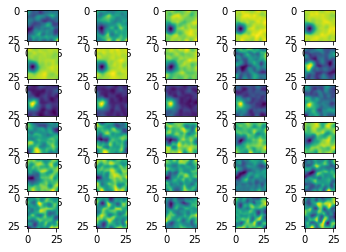

In [10]:
fig, ax = plt.subplots(6,5)
for i in range(30):
    ax.flatten()[i].imshow(STK[i,:,:])

In [11]:
rSTK = STK.reshape((-1,27*27))
U,sigma,VT=np.linalg.svd(rSTK)

# load files MB

In [12]:
file_list = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff=2_sort_unit2',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff=4_sort_unit2',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff=7_sort_unit2',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff=10_sort_unit2',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_original_tau=0p5_sort_unit2']
x_list = []
T_list = []
rstate_list = []
for file in file_list:
    annots = loadmat(file, squeeze_me = True)
    sampling_rate = 20000
    TimeStamps = annots['TimeStamps']
    x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
    x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/5), mode='reflect')
    x = x[::int(sampling_rate*dt)]
    x = x.astype(float)
    x = (x -np.mean(x))/np.std(x)
    T = np.arange(len(x)+1)*dt
    x_list.append( x.copy() )
    T_list.append( T.copy() )

In [13]:
tv_list = [ ndimage.gaussian_filter1d(x, order=1, sigma=1)/dt  for x in x_list ]
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

# Kernel response

## STA

In [14]:
# STK_onOLED = np.zeros([STK.shape[0], 600, 800])
# V1_onOLED = np.zeros([600, 800])
# for i in range(267):
#     for j in range(267):
#         STK_onOLED[:,i+300-1-133, j+400-1-133] = STK[:, int(i/267*27), int(j/267*27), cn-1]
#         V1_onOLED[i+300-1-133, j+400-1-133] = VT[0,:].reshape((27,27))[int(i/267*27), int(j/267*27)]

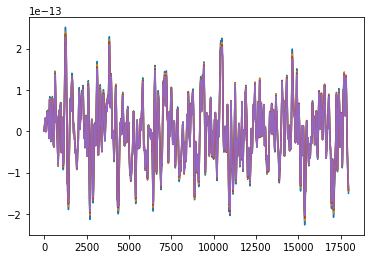

In [15]:
# STKr_list = [0]*len(x_list)
TK = np.sum( STK, axis=(1,2) )
# for i in range(len(x_list)):
#     BarPos = x_list[i].copy()
#     r = np.zeros(len(BarPos))
#     for k in range(len(BarPos)):
#         for kk in np.arange(k-STK.shape[0]+1, k):
#             r[k] += TK[k-kk] * BarPos[kk]
#     plt.plot(r)
#     STKr_list[i] = r.copy()
STKr_list = [np.convolve(x, TK, 'full')[:len(x)]*dt for x in x_list]
for r in STKr_list:
    plt.plot(r)

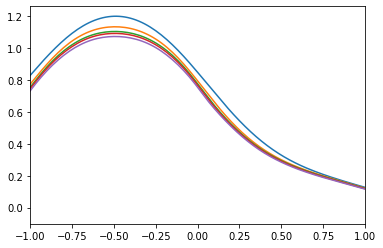

In [16]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt
STKXcorr = []
for i in range(len(x_list)):
    x = np.array(x_list[i])
#     x = np.array(x_list[i])
    x = (x-np.mean(x))/np.std(x)

    r = STKr_list[i].copy()
    r = NL(r, np.mean(r))
    
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    plt.plot(timeaxis,Xcorr)
    plt.xlim(window)
    STKXcorr.append( Xcorr.copy() )

## MI

In [17]:
STKrstate_list = [ SG(r, dt, 0, 2, 10) for r in STKr_list]

In [18]:
window = [-1,1] # second
STKInformation_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, STKInformation_list[i] = PIfunc(STKrstate_list[i], xstate_list[i], tvstate_list[i], dt, window)

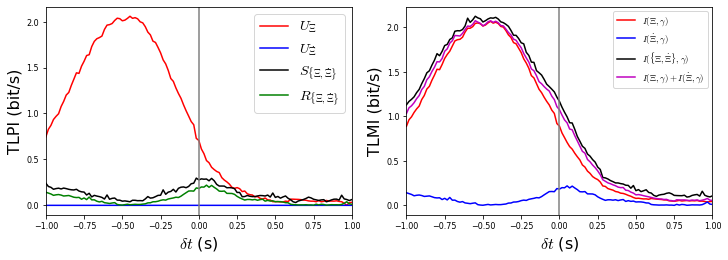

In [19]:
plt.rcParams["font.size"] = 8
i = 1
Information_list = STKInformation_list.copy()

fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax2.set_ylabel('TLPI (bit/s)', fontsize = 16)
ax2.legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 14})
ax2.axvline(0, c = 'gray')
ax2.set_xlim(window)

ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
ax3.plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                   +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
# ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax3.set_ylabel('TLMI (bit/s)', fontsize = 16)
ax3.axvline(0, c = 'gray')
ax3.set_xlim(window)
ax3.legend( (r'$I(\Xi,\gamma)$', r'$I(\dot\Xi,\gamma)$', r'$I(\{\Xi,\dot\Xi\},\gamma)$', r'$I(\Xi,\gamma)+I(\dot\Xi,\gamma)$'),
           loc='best', prop={'size': 9})


# fig.tight_layout(pad = 0, w_pad = 0.0, h_pad=0.0)
fig.set_size_inches(10, 3.5)

# SVD Kernel response

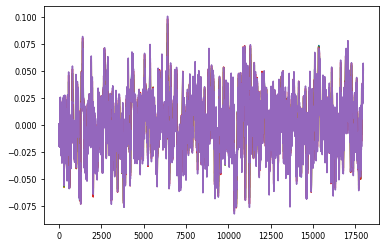

In [20]:
# SVDSTKr_list = [0]*len(x_list)
# for i in range(len(x_list)):
#     BarPos = x_list[i].astype('int')
#     r = np.zeros(len(BarPos))
#     uBarPos, uI = np.unique(BarPos, return_inverse=True)
#     SVDr = 6.5*np.array([np.sum(V1_onOLED[bp-100-BS['bar_wid']-1:bp-100+BS['bar_wid'],
#                                       400-BS['bar_le']-1:400+BS['bar_le']])  for bp in uBarPos])
#     SVDr = SVDr[uI]
#     SVDr = np.convolve(SVDr, U[:,0], 'full')[:len(SVDr)]*sigma[0]
    
#     plt.plot(SVDr)
#     SVDSTKr_list[i] = SVDr.copy()
    
SVDSTKr_list = [np.convolve(x, U[:,0], 'full')[:len(x)]*dt for x in x_list]
for r in SVDSTKr_list:
    plt.plot(r)

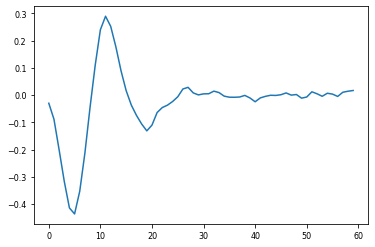

In [21]:
plt.plot( U[:,0] )

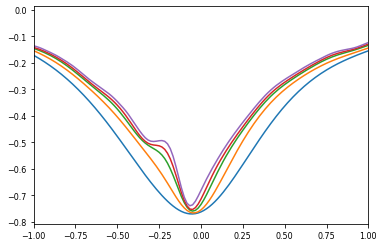

In [22]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt      
SVDSTKXcorr = []
for i in range(len(x_list)):
    x = np.array(x_list[i])
    x = (x-np.mean(x))/np.std(x)

    r = SVDSTKr_list[i].copy()
    r = NL(r, np.mean(r)-np.std(r))
    
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    plt.plot(timeaxis,Xcorr)
    plt.xlim(window)
    SVDSTKXcorr.append( Xcorr.copy() )

## MI

In [23]:
SVDSTKrstate_list = [ SG(r, dt, 0, 2, 10) for r in SVDSTKr_list]

In [24]:
window = [-1,1] # second
SVDSTKInformation_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, SVDSTKInformation_list[i] = PIfunc(SVDSTKrstate_list[i], xstate_list[i], tvstate_list[i], dt, window)

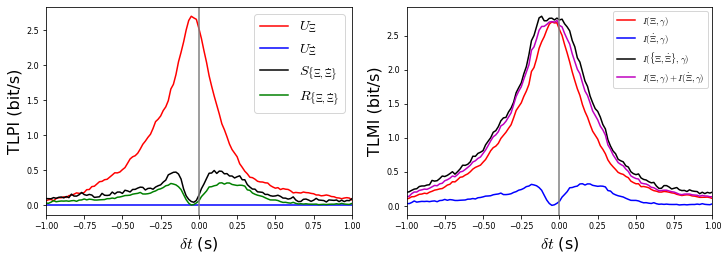

In [25]:
plt.rcParams["font.size"] = 8
i = 1
Information_list = SVDSTKInformation_list.copy()

fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax2.set_ylabel('TLPI (bit/s)', fontsize = 16)
ax2.legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 14})
ax2.axvline(0, c = 'gray')
ax2.set_xlim(window)

ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
ax3.plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                   +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
# ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax3.set_ylabel('TLMI (bit/s)', fontsize = 16)
ax3.axvline(0, c = 'gray')
ax3.set_xlim(window)
ax3.legend( (r'$I(\Xi,\gamma)$', r'$I(\dot\Xi,\gamma)$', r'$I(\{\Xi,\dot\Xi\},\gamma)$', r'$I(\Xi,\gamma)+I(\dot\Xi,\gamma)$'),
           loc='best', prop={'size': 9})


# fig.tight_layout(pad = 0, w_pad = 0.0, h_pad=0.0)
fig.set_size_inches(10, 3.5)